# Travel Domain Question Classification

Following program classifies questions related to travel domain using

1.   A combination of 5 text features & SVM
2.   Word embedding with FastText & SVM
3.   A LSTM classifier
4.   Using BERT for classification






### 1 - A combination of 5 text features & SVM

Imports the required libraries and the data file

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import sqlite3
import pickle
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

print('----- Importing dataset -----')
d_file = open('5000TravelQuestionsDataset.csv', encoding="latin-1")

df = pd.read_csv(d_file, header=None)
df.columns = ['text', 'class1', 'class2']

print ('Training Data : Imported Rows, Columns - ', df.shape)
print ('Data Preview :')
df.head()




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
----- Importing dataset -----
Training Data : Imported Rows, Columns -  (5000, 3)
Data Preview :


,text,class1,class2
0,What are the special things we (husband and me...,TTD,TTDSIG
1,What are the companies which organize shark fe...,TTD,TTDOTH
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA
3,What are the best places around Cape Town for ...,TTD,TTDSIG
4,What are the best places to stay for a family ...,ACM,ACMOTH


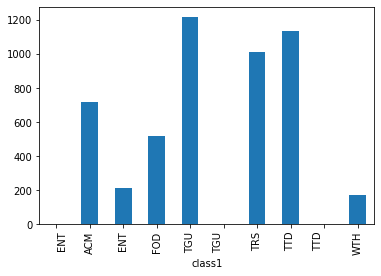

In [2]:
df.groupby('class1').text.count().plot.bar(ylim=0)
plt.show()

The following section performs the text normalizing steps by converting text to lower case, removing leading and trailing whitespaces & removing stop words.

#### 1.1 - Preprocessing

In [2]:
# Text normalization steps
import string

# Function to remove stop words
def remove_stopwords(text):
  text_tokens = nltk.word_tokenize(text) 
  filtered_sentence = [word for word in text_tokens if not word in stopwords.words()] 
  return " ".join(filtered_sentence)

# Converting to lower case 
df['processed_text'] = df['text'].str.lower()
# Removing punctuations
translator = str.maketrans('', '', string.punctuation)
df['processed_text'] = df['processed_text'].str.translate(translator)
# Removing leading ending white spaces
df['processed_text'] = df['processed_text'].str.strip()
# Remove stop words
df['processed_text'] = df.processed_text.apply(remove_stopwords)


# Removing leading ending white spaces
df['class1'] = df['class1'].str.strip()
df['class2'] = df['class2'].str.strip()

df.head()


,text,class1,class2,processed_text
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband 5 day stay cape town
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife


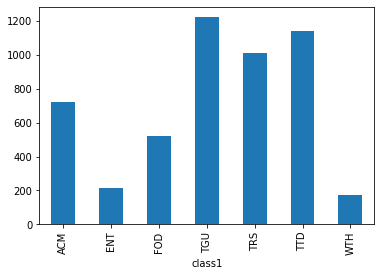

In [4]:
df.groupby('class1').text.count().plot.bar(ylim=0)
plt.show()

#### 1.2 - Lemmatizing

In [3]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in nltk.word_tokenize(text)]
  return ' '.join(lemmatized)

df['lemmatized'] = df.processed_text.apply(lemmatize_text)


#### 1.3 - POS Tagging

In [4]:
import nltk
nltk.download('averaged_perceptron_tagger')
# Modified POS tagger to retain words and apply tf idf vectoriser
def mod_pos_tagger(text):
    pos_tagged = [ r[0] + "_" + r[1] for r in pos_tag(nltk.word_tokenize(text))] 
    return ' '.join(pos_tagged)

df['pos_tagged'] = df.processed_text.apply(mod_pos_tagger)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#### 1.4 - Headword Extraction

In [5]:
import spacy

nlp = spacy.load('en_core_web_sm')
def head_word_tokenizer(text):
    head_words = []
    for token in nlp(text):
        if token.dep_ == "nsubj" or token.dep_ == "dobj" or token.dep_ == "aux" or token.dep_ == "ROOT":
            head_words.append(token.text)
            head_words.append(token.head.text)
    unique_hw = list(set(head_words))
    return unique_hw

df['headwords'] = df.processed_text.apply(head_word_tokenizer)


#### 1.5 - Headword Synonyms

In [6]:
from nltk.corpus import wordnet
max_syns = 2

def wordnet_synonyms(keywords):
  synonyms = []
  for keyword in keywords:
    count = 0
    for synset in wordnet.synsets(keyword):
      if count <= max_syns:
        for lemma in synset.lemmas():
          if count <= max_syns:
            synonyms.append(lemma.name())
          else: 
            break
        count = count + 1
      else:
        break

  unique_synonyms = list(set(synonyms))
  return ' '.join(synonyms)

df['headwords_synonyms'] = df.headwords.apply(wordnet_synonyms)


In [7]:
def join_strings(text):
  words = []
  for word in text:
    words.append(word)

  return ' '.join(words)

df['headwords'] = df.headwords.apply(join_strings)


#### 1.6 - Named Entity Recognition

In [8]:
def named_entity_tokenizer(text):
    named_entities = []
    for ent in nlp(text).ents:
      named_entities.append(ent.text + '_' + ent.label_)
    # unique_ent = list(set(named_entities))
    return ' '.join(named_entities)

df['named_entities'] = df.text.apply(named_entity_tokenizer)
df


,text,class1,class2,processed_text,lemmatized,pos_tagged,headwords,headwords_synonyms,named_entities
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband 5 day stay cape town,special things husband 5 day stay cape town,special_JJ things_NNS husband_VBP 5_CD day_NN ...,stay husband things,stay arrest check halt hitch stay stop stoppag...,5 day_DATE Cape Town_FAC
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...,company organize shark feed events scuba divers,companies_NNS organize_VBP shark_JJ feeding_VB...,divers companies organize,diver frogman underwater_diver diver plunger l...,
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town,safe female traveller go alone cape town,safe_JJ female_NN traveller_NN go_VBP alone_RB...,traveller go,traveler traveller go spell tour turn Adam ecs...,Cape Town_GPE
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari,best place around cape town safari,best_JJS places_NNS around_IN cape_NN town_NN ...,places,topographic_point place spot place property place,Cape Town_LOC safari_GPE
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife,best place stay family stay away nightlife,best_JJS places_NNS stay_VBP family_NN stay_VB...,stay family places,stay arrest check halt hitch stay stop stoppag...,
...,...,...,...,...,...,...,...,...,...
4995,What is the best area to be based for sightsee...,TTD,TTDSIG,best area based sightseeing palma,best area base sightsee palma,best_JJS area_NN based_VBN sightseeing_NN palm...,area,area country area area region,Palma_ORG
4996,What are the good value traditional bars and r...,FOD,FODBAR,good value traditional bars restaurants barcelona,good value traditional bar restaurants barcelona,good_JJ value_NN traditional_JJ bars_NNS resta...,barcelona restaurants bars,Barcelona restaurant eating_house eating_place...,Barcelona_GPE
4997,What are the hotels near Alicante bus station?,ACM,ACMHOT,hotels near alicante bus station,hotels near alicante bus station,hotels_NNS near_IN alicante_JJ bus_NN station_NN,hotels,hotel,
4998,Where to stay in La Gomera to mountain biking?,TTD,TTDSPO,stay gomera mountain biking,stay gomera mountain bike,stay_NN gomera_NN mountain_NN biking_NN,stay biking,stay arrest check halt hitch stay stop stoppag...,La Gomera_ORG


#### 1.7 - Label Encoder for Classes

In [9]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(text):
  le = LabelEncoder()
  y_encoded = le.fit_transform(text)

#### 1.8 - Vectorize

Vectorize with TF IDF vectorizer

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(text):
  tfidfconverter = TfidfVectorizer(max_features=1500, min_df=1, max_df=0.7, stop_words=stopwords.words('english'))
  vctzr = tfidfconverter.fit_transform(text).toarray()
  return vctzr

print('Bag of words -----')
tfidf_vectorize(df['lemmatized']).shape
print('Named Entity -----')
tfidf_vectorize(df['named_entities']).shape
print('Head Words -----')
tfidf_vectorize(df['headwords']).shape
print('Head Words Synonyms-----')
tfidf_vectorize(df['headwords_synonyms']).shape
print('POS tagged-----')
tfidf_vectorize(df['pos_tagged']).shape



Bag of words -----
Named Entity -----
Head Words -----
Head Words Synonyms-----
POS tagged-----


(5000, 1500)

#### 1.9 - Accuracy Calculation

In [11]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def accuracy_report(y_test, y_pred):
    
    print(classification_report(y_test,y_pred))

    acc = accuracy_score(y_test, y_pred)*100
    print('Accuracy : %.3f' % acc)

    f1 =  f1_score(y_test, y_pred, average='weighted')
    print('F1 Score: %.3f' % f1)

    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n{}".format(cm))

    return f1

#### 1.10 - Model Creation and Training

The model uses the following features


1.   Bag of words
2.   Headwords
3.   Synonyms of headwords
4.   POS tags
5.   Name Entitiy Relations




In [12]:
le = LabelEncoder()

x_encoded = np.concatenate((tfidf_vectorize(df['lemmatized']), tfidf_vectorize(df['named_entities']), tfidf_vectorize(df['headwords']), tfidf_vectorize(df['headwords_synonyms']), tfidf_vectorize(df['pos_tagged'])), axis=1)
y_encoded = le.fit_transform(df['class1'])

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def calculate_accuracy(encoded_x, encoded_y):
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  fold = 0
  accuracies = []
  for train_index, test_index in cv.split(x_encoded):
      fold += 1
      X_train, X_test = encoded_x[train_index], encoded_x[test_index]
      y_train, y_test = encoded_y[train_index], encoded_y[test_index]
      SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
      SVM.fit(X_train,y_train)
      predictions = SVM.predict(X_test)
      acc = accuracy_score(predictions, y_test)*100
      accuracies.append(acc)
      print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
      
  print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

  return predictions, y_test

#### 1.11 - Results - 5 features

In [ ]:
y_return = calculate_accuracy(x_encoded, y_encoded)

Fold: 1 - Accuracy:  - 79.00
Fold: 2 - Accuracy:  - 76.80
Fold: 3 - Accuracy:  - 74.80
Fold: 4 - Accuracy:  - 77.00
Fold: 5 - Accuracy:  - 74.40
Fold: 6 - Accuracy:  - 77.20
Fold: 7 - Accuracy:  - 74.40
Fold: 8 - Accuracy:  - 76.80
Fold: 9 - Accuracy:  - 75.00
Fold: 10 - Accuracy:  - 77.20
Mean 76.26 Standard Deviation 1.45


In [ ]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        78
           1       0.74      0.85      0.79        20
           2       0.83      0.89      0.86        56
           3       0.73      0.69      0.71       119
           4       0.86      0.82      0.84       102
           5       0.70      0.71      0.71       112
           6       0.76      1.00      0.87        13

    accuracy                           0.77       500
   macro avg       0.77      0.82      0.79       500
weighted avg       0.77      0.77      0.77       500

Accuracy : 77.200
F1 Score: 0.771
Confusion Matrix: 
[[60  0  3  4  3  7  1]
 [ 0 17  1  0  0  1  1]
 [ 2  1 50  2  1  0  0]
 [ 6  3  3 82  5 19  1]
 [ 1  1  0  8 84  7  1]
 [ 7  1  3 16  5 80  0]
 [ 0  0  0  0  0  0 13]]


0.7711851737726072

In [ ]:
le = LabelEncoder()

x_encoded = np.concatenate((tfidf_vectorize(df['lemmatized']), tfidf_vectorize(df['named_entities']), tfidf_vectorize(df['headwords']), tfidf_vectorize(df['headwords_synonyms']), tfidf_vectorize(df['pos_tagged'])), axis=1)
y_encoded = le.fit_transform(df['class2'])

In [ ]:
y_return = calculate_accuracy(x_encoded, y_encoded)

Fold: 1 - Accuracy:  - 58.40
Fold: 2 - Accuracy:  - 58.60
Fold: 3 - Accuracy:  - 58.40
Fold: 4 - Accuracy:  - 61.60
Fold: 5 - Accuracy:  - 58.00
Fold: 6 - Accuracy:  - 57.00
Fold: 7 - Accuracy:  - 55.20
Fold: 8 - Accuracy:  - 60.20
Fold: 9 - Accuracy:  - 58.40
Fold: 10 - Accuracy:  - 61.40
Mean 58.72 Standard Deviation 1.84


In [ ]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       0.38      1.00      0.55         3
           4       0.70      0.58      0.64        48
           5       0.76      0.64      0.70        25
           6       0.80      1.00      0.89         4
           7       0.00      0.00      0.00         3
           8       0.88      0.70      0.78        10
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.86      0.86      0.86         7
          12       0.00      0.00      0.00         0
          14       0.82      0.72      0.77        25
          15       0.75      0.86      0.80        14
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         1
          19       0.25      1.00      0.40         1
          20       0.50    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6277377072820639

#### 1.12 - Results - Removing Feature NER 
(Due to incompleteness - Certain records having null NER)

In [ ]:
le = LabelEncoder()

x_encoded = np.concatenate((tfidf_vectorize(df['lemmatized']), tfidf_vectorize(df['headwords']), tfidf_vectorize(df['headwords_synonyms']), tfidf_vectorize(df['pos_tagged'])), axis=1)
y_encoded = le.fit_transform(df['class1'])

In [ ]:
y_return = calculate_accuracy(x_encoded, y_encoded)

Fold: 1 - Accuracy:  - 80.40
Fold: 2 - Accuracy:  - 78.40
Fold: 3 - Accuracy:  - 76.20
Fold: 4 - Accuracy:  - 78.60
Fold: 5 - Accuracy:  - 76.00
Fold: 6 - Accuracy:  - 76.00
Fold: 7 - Accuracy:  - 75.80
Fold: 8 - Accuracy:  - 79.40
Fold: 9 - Accuracy:  - 75.80
Fold: 10 - Accuracy:  - 78.40
Mean 77.50 Standard Deviation 1.64


In [ ]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        74
           1       0.65      0.88      0.75        17
           2       0.87      0.91      0.89        57
           3       0.71      0.69      0.70       116
           4       0.90      0.85      0.87       104
           5       0.72      0.69      0.71       118
           6       0.82      1.00      0.90        14

    accuracy                           0.78       500
   macro avg       0.78      0.84      0.81       500
weighted avg       0.79      0.78      0.78       500

Accuracy : 78.400
F1 Score: 0.783
Confusion Matrix: 
[[61  1  2  4  1  4  1]
 [ 0 15  0  0  0  1  1]
 [ 2  2 52  1  0  0  0]
 [ 6  3  3 80  5 19  0]
 [ 0  1  0  7 88  8  0]
 [ 7  1  3 20  4 82  1]
 [ 0  0  0  0  0  0 14]]


0.7833593157703451

#### 1.13 - Results - Using only Bag of Words

In [ ]:
le = LabelEncoder()

x_encoded = tfidf_vectorize(df['lemmatized'])
y_encoded = le.fit_transform(df['class1'])

In [ ]:
y_return = calculate_accuracy(x_encoded, y_encoded)

Fold: 1 - Accuracy:  - 81.80
Fold: 2 - Accuracy:  - 80.60
Fold: 3 - Accuracy:  - 79.00
Fold: 4 - Accuracy:  - 78.80
Fold: 5 - Accuracy:  - 79.40
Fold: 6 - Accuracy:  - 79.60
Fold: 7 - Accuracy:  - 80.40
Fold: 8 - Accuracy:  - 80.00
Fold: 9 - Accuracy:  - 79.40
Fold: 10 - Accuracy:  - 80.80
Mean 79.98 Standard Deviation 0.88


In [ ]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        72
           1       0.74      0.94      0.83        18
           2       0.82      0.91      0.86        54
           3       0.74      0.76      0.75       109
           4       0.91      0.83      0.87       107
           5       0.79      0.71      0.75       126
           6       0.82      1.00      0.90        14

    accuracy                           0.81       500
   macro avg       0.80      0.86      0.83       500
weighted avg       0.81      0.81      0.81       500

Accuracy : 80.800
F1 Score: 0.807
Confusion Matrix: 
[[62  0  4  3  0  3  0]
 [ 0 17  0  0  0  1  0]
 [ 2  1 49  2  0  0  0]
 [ 4  2  4 83  4 12  0]
 [ 0  2  0  7 89  8  1]
 [ 8  1  3 17  5 90  2]
 [ 0  0  0  0  0  0 14]]


0.80719597551022

In [ ]:
le = LabelEncoder()

x_encoded = tfidf_vectorize(df['lemmatized'])
y_encoded = le.fit_transform(df['class2'])

In [ ]:
y_return = calculate_accuracy(x_encoded, y_encoded)

Fold: 1 - Accuracy:  - 62.00
Fold: 2 - Accuracy:  - 64.40
Fold: 3 - Accuracy:  - 65.00
Fold: 4 - Accuracy:  - 62.40
Fold: 5 - Accuracy:  - 65.40
Fold: 6 - Accuracy:  - 66.60
Fold: 7 - Accuracy:  - 63.80
Fold: 8 - Accuracy:  - 66.40
Fold: 9 - Accuracy:  - 63.80
Fold: 10 - Accuracy:  - 64.60
Mean 64.44 Standard Deviation 1.44


In [ ]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       0.62      1.00      0.77         5
           4       0.68      0.64      0.66        42
           5       0.81      0.74      0.77        23
           6       0.80      1.00      0.89         4
           7       0.00      0.00      0.00         2
           8       0.75      0.75      0.75         8
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.71      1.00      0.83         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.82      0.62      0.71        29
          15       0.81      1.00      0.90        13
          16       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         1
          19       0.25    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6630509280083172

### 2 - Word embedding with FastText & SVM

FastText classification

In [ ]:
!pip install fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

ft.get_dimension()

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3043253 sha256=71a89681ef3044002bd02a9fc4d42a7f81774dbe1413ace452daa2093172ee7f
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
Buffered data was truncated after reaching the output size limit.

In [20]:
def tokenize(text):
    temp = nlp(text)
    return [str(token) for token in temp if not token.is_stop]

tokenized = [tokenize(text) for text in df.lemmatized]

In [21]:
def get_sentence_embedding(wordlist):
  embedding=ft.get_sentence_vector(wordlist)
  return embedding
  
embeddings = [np.mean(np.array(list(map(get_sentence_embedding,token))),axis=0) for token in tokenized]

x_encoded = np.array(embeddings)
x_encoded.shape

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_encoded = le.fit_transform(df['class1'])
y_encoded_1 = le.fit_transform(df['class2'])

#### 2.1 - Results - Word Embedding FastText

In [24]:
y_return = calculate_accuracy(x_encoded, y_encoded)

Fold: 1 - Accuracy:  - 76.00
Fold: 2 - Accuracy:  - 77.20
Fold: 3 - Accuracy:  - 76.60
Fold: 4 - Accuracy:  - 77.60
Fold: 5 - Accuracy:  - 77.60
Fold: 6 - Accuracy:  - 77.40
Fold: 7 - Accuracy:  - 75.40
Fold: 8 - Accuracy:  - 77.80
Fold: 9 - Accuracy:  - 78.40
Fold: 10 - Accuracy:  - 79.00
Mean 77.30 Standard Deviation 1.02


In [25]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.78      0.86      0.81        69
           1       0.35      0.80      0.48        10
           2       0.82      0.94      0.87        52
           3       0.76      0.77      0.77       110
           4       0.89      0.86      0.87       101
           5       0.82      0.65      0.72       144
           6       0.82      1.00      0.90        14

    accuracy                           0.79       500
   macro avg       0.75      0.84      0.78       500
weighted avg       0.80      0.79      0.79       500

Accuracy : 79.000
F1 Score: 0.791
Confusion Matrix: 
[[59  1  1  3  0  4  1]
 [ 0  8  1  0  1  0  0]
 [ 2  0 49  0  0  1  0]
 [ 7  3  2 85  3  9  1]
 [ 0  1  0  6 87  7  0]
 [ 8 10  7 18  7 93  1]
 [ 0  0  0  0  0  0 14]]


0.7910102315765789

In [26]:
y_return = calculate_accuracy(x_encoded, y_encoded_1)

Fold: 1 - Accuracy:  - 55.80
Fold: 2 - Accuracy:  - 54.20
Fold: 3 - Accuracy:  - 54.40
Fold: 4 - Accuracy:  - 52.20
Fold: 5 - Accuracy:  - 54.40
Fold: 6 - Accuracy:  - 54.40
Fold: 7 - Accuracy:  - 50.60
Fold: 8 - Accuracy:  - 54.40
Fold: 9 - Accuracy:  - 55.00
Fold: 10 - Accuracy:  - 53.60
Mean 53.90 Standard Deviation 1.41


In [27]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.70      0.50      0.58        56
           5       0.38      0.47      0.42        17
           6       0.20      1.00      0.33         1
           7       0.00      0.00      0.00         1
           8       0.38      1.00      0.55         3
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          14       0.82      0.50      0.62        36
          15       0.56      1.00      0.72         9
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       1.00      0.50      0.67         2
          19       0.00      0.00      0.00         0
          20       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5786442986671427

### 3 - LSTM Classifier

#### 3.1 - Data Encoding

In [28]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_encoded = le.fit_transform(df['class1'])
y_encoded_1 = le.fit_transform(df['class2'])

In [29]:
max_words = 5000
max_len = 25
tok = Tokenizer(num_words=max_words, split=' ')
tok.fit_on_texts(df.processed_text.values)
seqs = tok.texts_to_sequences(df.lemmatized.values)
seqs_mat = sequence.pad_sequences(seqs,maxlen=max_len)

seqs_mat.shape

(5000, 25)

#### 3.2 - Model Creation and Training

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SpatialDropout1D
def MODEL_LSTM(num_classes):
    model = Sequential()
    model.add(Embedding(5000, 160, input_length=seqs_mat.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [31]:
y_mat = pd.get_dummies(df['class1']).values
y_mat.shape

(5000, 7)

In [32]:
y_mat_1 = pd.get_dummies(df['class2']).values
y_mat_1.shape

(5000, 63)

In [34]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def evaluate_nn(seqs, seqs_mat, y_mat, num_classes):
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  fold = 0
  accuracies = []
  for train_index, test_index in cv.split(seqs):
    fold += 1
    X_train, X_test = seqs_mat[train_index], seqs_mat[test_index]
    y_train, y_test = y_mat[train_index], y_mat[test_index]

    model = MODEL_LSTM(num_classes)
    model.fit(X_train, y_train, epochs=5, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

    predictions = model.predict(X_test)

    fine_pred = [np.argmax(p) for p in predictions]
    fine_gt = [np.argmax(p) for p in y_test]
    f1 = accuracy_report(fine_pred, fine_gt)

    accuracies.append(f1)
    
  print("Mean {:.2f} Std {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

#### 3.3 - Results - LSTM

In [35]:
evaluate_nn(seqs, seqs_mat, y_mat, 7)

Epoch 1/5
64/64 [==============================] - 12s 190ms/step - loss: 1.7265 - accuracy: 0.3040 - val_loss: 1.8441 - val_accuracy: 0.1467
Epoch 2/5
64/64 [==============================] - 12s 183ms/step - loss: 0.9875 - accuracy: 0.6696 - val_loss: 1.4504 - val_accuracy: 0.4422
Epoch 3/5
64/64 [==============================] - 12s 185ms/step - loss: 0.5295 - accuracy: 0.8279 - val_loss: 1.0327 - val_accuracy: 0.6733
Epoch 4/5
64/64 [==============================] - 12s 183ms/step - loss: 0.2922 - accuracy: 0.9106 - val_loss: 1.0668 - val_accuracy: 0.6933
Epoch 5/5
64/64 [==============================] - 12s 185ms/step - loss: 0.1629 - accuracy: 0.9531 - val_loss: 0.9846 - val_accuracy: 0.7156
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        72
           1       0.52      0.50      0.51        26
           2       0.80      0.79      0.80        57
           3       0.87      0.68      0.76       135
           4       

In [36]:
evaluate_nn(seqs, seqs_mat, y_mat_1, 63)

Epoch 1/5
64/64 [==============================] - 12s 190ms/step - loss: 3.7439 - accuracy: 0.0765 - val_loss: 3.4834 - val_accuracy: 0.3089
Epoch 2/5
64/64 [==============================] - 12s 185ms/step - loss: 3.5696 - accuracy: 0.1123 - val_loss: 3.1721 - val_accuracy: 0.2867
Epoch 3/5
64/64 [==============================] - 12s 185ms/step - loss: 2.7276 - accuracy: 0.3422 - val_loss: 2.3358 - val_accuracy: 0.4244
Epoch 4/5
64/64 [==============================] - 12s 186ms/step - loss: 1.7193 - accuracy: 0.5958 - val_loss: 2.0537 - val_accuracy: 0.5356
Epoch 5/5
64/64 [==============================] - 12s 185ms/step - loss: 1.1285 - accuracy: 0.7232 - val_loss: 2.0081 - val_accuracy: 0.4956


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.62      0.52      0.57        48
           5       0.45      0.67      0.54        15
           6       0.86      0.46      0.60        13
           7       0.17      1.00      0.29         1
           8       0.50      0.67      0.57         6
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.50      0.50      0.50         4
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.80      0.65      0.71        31
          15       0.50      0.29      0.36         7
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.25      1.00      0.40         1
           3       0.00      0.00      0.00         0
           4       0.83      0.45      0.58        78
           5       0.50      0.50      0.50        22
           6       0.70      0.78      0.74         9
           7       0.20      0.33      0.25         3
           8       0.53      1.00      0.70         8
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.50      0.20      0.29         5
          13       0.00      0.00      0.00         1
          14       0.84      0.80      0.82        20
          15       0.75      0.43      0.55         7
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         2
          19       0.00    

### 4 - BERT based classifier

#### 4.1 - Categorical labeling

In [14]:
possible_labels_1 = df.class1.unique()
possible_labels_2 = df.class2.unique()

label_dict_1 = {}
for index, possible_label in enumerate(possible_labels_1):
    label_dict_1[possible_label] = index
label_dict_1

{'ACM': 2, 'ENT': 6, 'FOD': 5, 'TGU': 1, 'TRS': 3, 'TTD': 0, 'WTH': 4}

In [15]:
label_dict_2 = {}
for index, possible_label in enumerate(possible_labels_2):
    label_dict_2[possible_label] = index
label_dict_2

{'ACMAPA': 9,
 'ACMBEA': 40,
 'ACMBUN': 15,
 'ACMCAR': 52,
 'ACMHOT': 28,
 'ACMOTH': 3,
 'ACMRES': 14,
 'ENTCLB': 34,
 'ENTFES': 49,
 'ENTMUS': 57,
 'ENTOTH': 62,
 'ENTSHW': 54,
 'ENTSPO': 58,
 'FODAUT': 22,
 'FODBAK': 30,
 'FODBAR': 47,
 'FODBRE': 32,
 'FODCAT': 46,
 'FODCOT': 41,
 'FODFCA': 61,
 'FODFMA': 53,
 'FODOTH': 20,
 'TGUAPT': 42,
 'TGUATT': 33,
 'TGUAVE': 35,
 'TGUBAN': 5,
 'TGUCIG': 37,
 'TGUHEA': 2,
 'TGUHOL': 48,
 'TGULAU': 44,
 'TGULUG': 29,
 'TGUNEI': 7,
 'TGUOTH': 13,
 'TGUPLN': 24,
 'TGURES': 51,
 'TGURUL': 50,
 'TGUTEL': 36,
 'TGUTOP': 19,
 'TGUVIS': 21,
 'TGUWEB': 59,
 'TRSAIR': 11,
 'TRSBUS': 27,
 'TRSCRS': 16,
 'TRSDRV': 60,
 'TRSGAS': 55,
 'TRSLIC': 43,
 'TRSOTH': 10,
 'TRSRNT': 18,
 'TRSROU': 12,
 'TRSTAX': 25,
 'TRSTCD': 39,
 'TRSTRN': 4,
 'TTDGYM': 45,
 'TTDOTH': 1,
 'TTDSHP': 38,
 'TTDSIG': 0,
 'TTDSPA': 31,
 'TTDSPO': 8,
 'TTDTRI': 23,
 'WTHDRC': 17,
 'WTHOTH': 26,
 'WTHSNW': 56,
 'WTHTMP': 6}

In [16]:
df['class1_enc'] = df.class1.replace(label_dict_1)
df['class2_enc'] = df.class2.replace(label_dict_2)
df.head(10)

,text,class1,class2,processed_text,lemmatized,pos_tagged,headwords,headwords_synonyms,named_entities,class1_enc,class2_enc
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband 5 day stay cape town,special things husband 5 day stay cape town,special_JJ things_NNS husband_VBP 5_CD day_NN ...,stay husband things,stay arrest check halt hitch stay stop stoppag...,5 day_DATE Cape Town_FAC,0,0
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...,company organize shark feed events scuba divers,companies_NNS organize_VBP shark_JJ feeding_VB...,divers companies organize,diver frogman underwater_diver diver plunger l...,,0,1
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town,safe female traveller go alone cape town,safe_JJ female_NN traveller_NN go_VBP alone_RB...,traveller go,traveler traveller go spell tour turn Adam ecs...,Cape Town_GPE,1,2
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari,best place around cape town safari,best_JJS places_NNS around_IN cape_NN town_NN ...,places,topographic_point place spot place property place,Cape Town_LOC safari_GPE,0,0
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife,best place stay family stay away nightlife,best_JJS places_NNS stay_VBP family_NN stay_VB...,stay family places,stay arrest check halt hitch stay stop stoppag...,,2,3
5,What are the train services that travels from ...,TRS,TRSTRN,train services travels cape town oudtshoorn,train service travel cape town oudtshoorn,train_NN services_NNS travels_JJ cape_VBP town...,travels services oudtshoorn,travel traveling travelling change_of_location...,Oudtshoorn_LOC,3,4
6,What are the best places to spend about 2 week...,ACM,ACMOTH,best places spend 2 weeks relaxing honeymoon s...,best place spend 2 weeks relax honeymoon south...,best_JJS places_NNS spend_VBP 2_CD weeks_NNS r...,relaxing spend africa places,relax loosen_up unbend unwind decompress slow_...,about 2 weeks_DATE South Africa_GPE,2,3
7,Can we use travellers cheques and credit cards...,TGU,TGUBAN,use travellers cheques credit cards cape town,use travellers cheque credit card cape town,use_NN travellers_NNS cheques_NNS credit_NN ca...,cards travellers cape use town,card_game cards card card identity_card travel...,Cape Town_GPE,1,5
8,Is it warm enough to swim in early September i...,WTH,WTHTMP,warm enough swim early september cape town,warm enough swim early september cape town,warm_JJ enough_RB swim_VBP early_JJ september_...,swim,swimming swim swim float swim,early September_DATE Cape Town_GPE,4,6
9,What are the best beaches for shelling in Cape...,TTD,TTDSIG,best beaches shelling capetown,best beach shell capetown,best_JJS beaches_NNS shelling_VBG capetown_NN,shelling capetown beaches,barrage barrage_fire battery bombardment shell...,,0,0


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.class1_enc.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.class1_enc.values)

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(df.index.values, 
                                                  df.class2_enc.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.class2_enc.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.loc[X_train_1, 'data_type'] = 'train'
df.loc[X_val_1, 'data_type'] = 'val'

df.groupby(['class1', 'class1_enc', 'data_type']).count()

text  class2  ...  named_entities  class2_enc
class1 class1_enc data_type                ...                            
ACM    2          train       612     612  ...             612         612
                  val         108     108  ...             108         108
ENT    6          train       184     184  ...             184         184
                  val          32      32  ...              32          32
FOD    5          train       442     442  ...             442         442
                  val          79      79  ...              79          79
TGU    1          train      1038    1038  ...            1038        1038
                  val         182     182  ...             182         182
TRS    3          train       860     860  ...             860         860
                  val         151     151  ...             151         151
TTD    0          train       968     968  ...             968         968
                  val         172     172  ...             172         172
WTH    4          train       146     146  ...             146         146
                  val          26      26  ...              26          26

[14 rows x 9 columns]

In [18]:
df.groupby(['class2', 'class2_enc', 'data_type']).count()

text  class1  ...  named_entities  class1_enc
class2 class2_enc data_type                ...                            
ACMAPA 9          train        25      25  ...              25          25
                  val           4       4  ...               4           4
ACMBEA 40         train         4       4  ...               4           4
                  val           1       1  ...               1           1
ACMBUN 15         train        45      45  ...              45          45
...                           ...     ...  ...             ...         ...
WTHOTH 26         val          20      20  ...              20          20
WTHSNW 56         train         6       6  ...               6           6
                  val           1       1  ...               1           1
WTHTMP 6          train        17      17  ...              17          17
                  val           3       3  ...               3           3

[124 rows x 9 columns]

In [19]:
!pip install transformers

import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].lemmatized.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].lemmatized.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].class1_enc.values)
labels_train_1 = torch.tensor(df[df.data_type=='train'].class2_enc.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].class1_enc.values)
labels_val_1 = torch.tensor(df[df.data_type=='val'].class2_enc.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_train_1 = TensorDataset(input_ids_train, attention_masks_train, labels_train_1)
dataset_val_1 = TensorDataset(input_ids_val, attention_masks_val, labels_val_1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### 4.2 -Model and classification

In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [24]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, dict):
    label_dict_inverse = {v: k for k, v in dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [25]:
import random
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

device = torch.device("cuda:0")
# device = torch.device("cpu")

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.to(device)
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        # optimizer = optim.Adam(model.parameters())
        optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
        # optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 1
Training loss: 1.082648652904761
Validation loss: 0.7222361739873886
F1 Score (Weighted): 0.8034213517465671



Epoch 2
Training loss: 0.8169407870614851
Validation loss: 1.2928685138959117
F1 Score (Weighted): 0.8097457411874276



Epoch 3
Training loss: 0.8533131820876761
Validation loss: 1.3564080978422162
F1 Score (Weighted): 0.8547476100885473



Epoch 4
Training loss: 0.6517595745880173
Validation loss: 1.6415665912841766
F1 Score (Weighted): 0.8587284408036678



Epoch 5
Training loss: 0.5016813123728707
Validation loss: 1.6598720313401338
F1 Score (Weighted): 0.862121841386139



#### 4.3 - Resuts - BERT Class 1

In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cuda:0')))

_, predictions, true_vals = evaluate(dataloader_validation)
    
fine_pred = [np.argmax(p) for p in predictions]
fine_gt = [np.argmax(p) for p in true_vals]

val_acc = accuracy_score(fine_gt, fine_pred)*100
f1 =  f1_score(fine_pred, fine_gt, average='weighted')

print(classification_report(fine_gt,fine_pred))
print('Accuracy : %.3f' % val_acc)
print('F1 Score: %.3f' % f1)
cm = confusion_matrix(fine_gt, fine_pred)
print("Confusion Matrix: \n{}".format(cm))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

              precision    recall  f1-score   support

           0       1.00      0.30      0.46       750
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.30       750
   macro avg       0.14      0.04      0.07       750
weighted avg       1.00      0.30      0.46       750

Accuracy : 29.867
F1 Score: 0.137
Confusion Matrix: 
[[224 170 101 133  22  88  12]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 4.4 - Results - BERT Class 2

In [27]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_2),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train_1, 
                              sampler=RandomSampler(dataset_train_1), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val_1, 
                                   sampler=SequentialSampler(dataset_val_1), 
                                   batch_size=batch_size)

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [30]:
import random
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


device = torch.device("cuda:0")
# device = torch.device("cpu")

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.to(device)
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        # optimizer = optim.Adam(model.parameters())
        optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
        # optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 1
Training loss: 3.423845920751191
Validation loss: 2.740895845890045
F1 Score (Weighted): 0.3455859484359001



Epoch 2
Training loss: 2.360358585205899
Validation loss: 2.046072925031185
F1 Score (Weighted): 0.5029582976672731



Epoch 3
Training loss: 1.7675524685234778
Validation loss: 1.7619192834347486
F1 Score (Weighted): 0.5633621679780026



Epoch 4
Training loss: 1.430702118985171
Validation loss: 1.735684908684343
F1 Score (Weighted): 0.58999235188168



Epoch 5
Training loss: 1.213653727403685
Validation loss: 1.7711989096691831
F1 Score (Weighted): 0.6128403047354685



In [32]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_2),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cuda:0')))

_, predictions, true_vals = evaluate(dataloader_validation)
    
fine_pred = [np.argmax(p) for p in predictions]
fine_gt = [np.argmax(p) for p in true_vals]

val_acc = accuracy_score(fine_gt, fine_pred)*100
f1 =  f1_score(fine_pred, fine_gt, average='weighted')

print(classification_report(fine_gt,fine_pred))
print('Accuracy : %.3f' % val_acc)
print('F1 Score: %.3f' % f1)
cm = confusion_matrix(fine_gt, fine_pred)
print("Confusion Matrix: \n{}".format(cm))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

              precision    recall  f1-score   support

           0       1.00      0.31      0.48       750
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         0
          38       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         0
          49       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_2),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_4.model', map_location=torch.device('cuda:0')))

_, predictions, true_vals = evaluate(dataloader_validation)
    
fine_pred = [np.argmax(p) for p in predictions]
fine_gt = [np.argmax(p) for p in true_vals]

val_acc = accuracy_score(fine_gt, fine_pred)*100
f1 =  f1_score(fine_pred, fine_gt, average='weighted')

print(classification_report(fine_gt,fine_pred))
print('Accuracy : %.3f' % val_acc)
print('F1 Score: %.3f' % f1)
cm = confusion_matrix(fine_gt, fine_pred)
print("Confusion Matrix: \n{}".format(cm))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

              precision    recall  f1-score   support

           0       1.00      0.14      0.24       750
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 4.5 - BERT modified

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.class1_enc.values, 
                                                  test_size=0.5, 
                                                  random_state=1, 
                                                  stratify=df.class1_enc.values)

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(df.index.values, 
                                                  df.class2_enc.values, 
                                                  test_size=0.5, 
                                                  random_state=1, 
                                                  stratify=df.class2_enc.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.loc[X_train_1, 'data_type'] = 'train'
df.loc[X_val_1, 'data_type'] = 'val'

df.groupby(['class1', 'class1_enc', 'data_type']).count()

text  class2  ...  named_entities  class2_enc
class1 class1_enc data_type                ...                            
ACM    2          train       360     360  ...             360         360
                  val         360     360  ...             360         360
ENT    6          train       107     107  ...             107         107
                  val         109     109  ...             109         109
FOD    5          train       260     260  ...             260         260
                  val         261     261  ...             261         261
TGU    1          train       613     613  ...             613         613
                  val         607     607  ...             607         607
TRS    3          train       504     504  ...             504         504
                  val         507     507  ...             507         507
TTD    0          train       570     570  ...             570         570
                  val         570     570  ...             570         570
WTH    4          train        86      86  ...              86          86
                  val          86      86  ...              86          86

[14 rows x 9 columns]

In [36]:
df.groupby(['class2', 'class2_enc', 'data_type']).count()

text  class1  ...  named_entities  class1_enc
class2 class2_enc data_type                ...                            
ACMAPA 9          train        15      15  ...              15          15
                  val          14      14  ...              14          14
ACMBEA 40         train         3       3  ...               3           3
                  val           2       2  ...               2           2
ACMBUN 15         train        26      26  ...              26          26
...                           ...     ...  ...             ...         ...
WTHOTH 26         val          68      68  ...              68          68
WTHSNW 56         train         4       4  ...               4           4
                  val           3       3  ...               3           3
WTHTMP 6          train        10      10  ...              10          10
                  val          10      10  ...              10          10

[126 rows x 9 columns]

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].class1_enc.values)
labels_train_1 = torch.tensor(df[df.data_type=='train'].class2_enc.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].class1_enc.values)
labels_val_1 = torch.tensor(df[df.data_type=='val'].class2_enc.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_train_1 = TensorDataset(input_ids_train, attention_masks_train, labels_train_1)
dataset_val_1 = TensorDataset(input_ids_val, attention_masks_val, labels_val_1)





model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

													  

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
								   


from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

In [38]:
import random
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

device = torch.device("cuda:0")
# device = torch.device("cpu")

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.to(device)
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        # optimizer = optim.Adam(model.parameters())
        optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
        # optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 1
Training loss: 1.1693938819678138
Validation loss: 0.6230578758157521
F1 Score (Weighted): 0.8104169314683533



Epoch 2
Training loss: 0.5628868083931462
Validation loss: 0.8591823080383332
F1 Score (Weighted): 0.850415674713458



Epoch 3
Training loss: 0.5381199386994652
Validation loss: 1.2363674195913796
F1 Score (Weighted): 0.860888758324445



Epoch 4
Training loss: 0.4397591731215313
Validation loss: 1.3735553155374285
F1 Score (Weighted): 0.8669522294615097



Epoch 5
Training loss: 0.29755098715933415
Validation loss: 1.6292280677525275
F1 Score (Weighted): 0.8543572591057899



In [40]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cuda:0')))

_, predictions, true_vals = evaluate(dataloader_validation)
    
fine_pred = [np.argmax(p) for p in predictions]
fine_gt = [np.argmax(p) for p in true_vals]

val_acc = accuracy_score(fine_gt, fine_pred)*100
f1 =  f1_score(fine_pred, fine_gt, average='weighted')

print(classification_report(fine_gt,fine_pred))
print('Accuracy : %.3f' % val_acc)
print('F1 Score: %.3f' % f1)
cm = confusion_matrix(fine_gt, fine_pred)
print("Confusion Matrix: \n{}".format(cm))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

              precision    recall  f1-score   support

           0       1.00      0.19      0.32      2500
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.19      2500
   macro avg       0.14      0.03      0.05      2500
weighted avg       1.00      0.19      0.32      2500

Accuracy : 18.760
F1 Score: 0.059
Confusion Matrix: 
[[469 617 369 567  73 342  63]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
